# Variational Auto encoder for fraud detection

In [1]:
import tensorflow as tf
import numpy as np
import os, sys
from utils import mvt2mixture          # for drawing random samples from a multivariate Mixture distr.
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, f1_score, accuracy_score
import scikitplot as skplt            # confusion matrix
import matplotlib.animation as animation


# to make output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
FILE = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", FILE, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    

In [2]:
#plt.rcParams.keys()

# Read in real UK fraud data:

Note: The data has already been preprocessed (i.e. it includes CBOW stuff etc.)

In [3]:
fraud_data = pd.read_pickle("/work/Alex/Notebooks/data/UK_FraudData_preproc.pkl")

In [4]:
fraud_data.shape

(107267, 314)

In [5]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107267 entries, 0 to 0
Columns: 314 entries, var_AddChk to var_weekday_NotifDate_Others
dtypes: float64(314)
memory usage: 257.8 MB


In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(fraud_data.head())

,var_AddChk,var_AverageClaimCount_per_AllPolicy,var_AvgClaimsValuePerPolicy,var_Claim Reference_Insured Name Code,var_Claim Reference_Policy Number,var_claimantCount,var_diff_DoL_ExpDate,var_diff_DoL_InceptDate,var_diff_DoL_Min_Policy_IncpDate,var_diff_NotifDate_DoL,var_FraudText,var_is_accident/naturalCause,var_isCommercialFire,var_IsHoliday_DoL,var_IsHoliday_NotifDate,var_LossNearExpiry,Var_ManyClaims,var_NewPol,var_NofDaysPrevClaimPerClaimant Name,var_NofDaysPrevClaimPerInsured Name,var_NofRecentClaimsPerLOB,var_NofYearsSinceInception,var_Policy Number_Insured Name Code,Claim Description_0,Claim Description_1,Claim Description_2,Claim Description_3,Claim Description_4,Claim Description_5,Claim Description_6,Claim Description_7,Claim Description_8,Claim Description_9,Claim Description_10,Claim Description_11,Claim Description_12,Claim Description_13,Claim Description_14,Claim Description_15,Claim Description_16,Claim Description_17,Claim Description_18,Claim Description_19,Claim Description_20,Claim Description_21,Claim Description_22,Claim Description_23,Claim Description_24,Claim Description_25,Claim Description_26,Claim Description_27,Claim Description_28,Claim Description_29,Claim Description_30,Claim Description_31,Claim Description_32,Claim Description_33,Claim Description_34,Claim Description_35,Claim Description_36,Claim Description_37,Claim Description_38,Claim Description_39,Claim Description_40,Claim Description_41,Claim Description_42,Claim Description_43,Claim Description_44,Claim Description_45,Claim Description_46,Claim Description_47,Loss Analysis 1 Description_0,Loss Analysis 1 Description_1,Loss Analysis 1 Description_2,Loss Analysis 1 Description_3,Loss Analysis 1 Description_4,Loss Analysis 1 Description_5,Loss Analysis 1 Description_6,Loss Analysis 1 Description_7,Loss Analysis 1 Description_8,Loss Analysis 1 Description_9,Loss Analysis 1 Description_10,Loss Analysis 1 Description_11,Loss Analysis 1 Description_12,Loss Analysis 1 Description_13,Loss Analysis 1 Description_14,Loss Analysis 1 Description_15,Loss Analysis 1 Description_16,Loss Analysis 1 Description_17,Loss Analysis 1 Description_18,Loss Analysis 1 Description_19,Loss Analysis 1 Description_20,Loss Analysis 1 Description_21,Loss Analysis 1 Description_22,Loss Analysis 1 Description_23,Loss Analysis 1 Description_24,Loss Analysis 1 Description_25,Loss Analysis 1 Description_26,Loss Analysis 1 Description_27,Loss Analysis 1 Description_28,Loss Analysis 1 Description_29,Loss Analysis 1 Description_30,Loss Analysis 1 Description_31,Loss Analysis 1 Description_32,Loss Analysis 1 Description_33,Loss Analysis 1 Description_34,Loss Analysis 1 Description_35,Loss Analysis 1 Description_36,Loss Analysis 1 Description_37,Loss Analysis 1 Description_38,Loss Analysis 1 Description_39,Loss Analysis 1 Description_40,Loss Analysis 1 Description_41,Loss Analysis 1 Description_42,Loss Analysis 1 Description_43,Loss Analysis 1 Description_44,Loss Analysis 1 Description_45,Loss Analysis 1 Description_46,Loss Analysis 1 Description_47,Loss Analysis 2 Description_0,Loss Analysis 2 Description_1,Loss Analysis 2 Description_2,Loss Analysis 2 Description_3,Loss Analysis 2 Description_4,Loss Analysis 2 Description_5,Loss Analysis 2 Description_6,Loss Analysis 2 Description_7,Loss Analysis 2 Description_8,Loss Analysis 2 Description_9,Loss Analysis 2 Description_10,Loss Analysis 2 Description_11,Loss Analysis 2 Description_12,Loss Analysis 2 Description_13,Loss Analysis 2 Description_14,Loss Analysis 2 Description_15,Loss Analysis 2 Description_16,Loss Analysis 2 Description_17,Loss Analysis 2 Description_18,Loss Analysis 2 Description_19,Loss Analysis 2 Description_20,Loss Analysis 2 Description_21,Loss Analysis 2 Description_22,Loss Analysis 2 Description_23,Loss Analysis 2 Description_24,Loss Analysis 2 Description_25,Loss Analysis 2 Description_26,Loss Analysis 2 Description_27,Loss Analysis 2 Description_28,Loss Analysis 2 Description_29,Loss Analysis 2 Descript

Split the data:

In [45]:
X_train, X_test = train_test_split(fraud_data, test_size = 0.2, random_state = 42, shuffle = True)


In [46]:
X_train.shape

(85813, 314)

# Simulation experiment:

### Draw random sample from Student-t (or Gaussian) - mixture distribution:

In [7]:
p = .005         # probab. for outlier -> 1
k = 300           # feature dimension 
N = 1*10**5

bvt = mvt2mixture(thetas = {'mean1' : np.full(k,-1), 'mean2' : np.full(k,2), \
                            'Sigma1' : np.eye(k)*.1, 'Sigma2' : np.eye(k)*.2, \
                            'nu1': 3.*k, 'nu2': 3.*k}, seed = None, gaussian = True)

# Get latent draws and observations:
#------------------------------------
z_is, dataset = bvt.draw(n_samples = N, k = k, p = p)

dataset.shape

(100000, 300)

In [8]:
z_is.mean()

0.00493

Dataset with latent values (outlier non-outlier)

In [9]:
#dat = pd.concat([pd.DataFrame(z_is, columns=['outlier']), pd.DataFrame(dataset)], axis = 1)
#dat.head(5)           # 1 means outlier

Plot the data:

In [10]:
#bvt.show2D(alpha = .15)

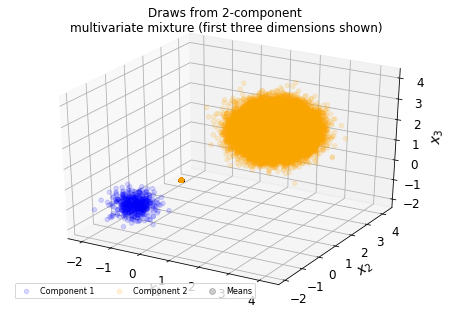

In [11]:
bvt.show3D(alpha = .15)

## Prepare simulated data

Separate 'normal' from 'non-normal' observations: 

In [12]:
latent = z_is 
dataset = pd.DataFrame(dataset)
data_only_outliers = dataset[latent == 1]
data_no_outliers = dataset[latent == 0]

Take non-outlier part and split it into training and testing fold:

In [13]:
# No outliers
X_train, X_test = train_test_split(data_no_outliers, test_size = 0.2, random_state = 42, shuffle = True)

In [14]:
X_test1 = X_test.copy()            # no outliers
print(X_test1.shape)

X_test2 = data_only_outliers.copy()       # only outliers
print(X_test2.shape)

(19902, 300)
(493, 300)


In [15]:
X_train.shape
#X_test.shape

(79605, 300)

Test fold: 
 - Join block without outliers and outlier (only) block together, so that the test fold now comprises both sorts of data

In [16]:
X_test_temp = X_test.assign(latent=0)                          # add outlier indicator column
data_only_outliers = data_only_outliers.assign(latent=1)       # same

# X_test with both:
X_test_with_out = data_only_outliers.append(pd.DataFrame(X_test_temp)).sample(frac=1)          # append and shuffle

In [17]:
X_test.shape

(19902, 300)

In [18]:
X_test_new = X_test_with_out.drop('latent',axis=1)        # drop outlier indicator for the training

## Split and scale the data:

In [51]:

scaler = MinMaxScaler().fit(X_train)
#scaler = StandardScaler().fit(X_train)     # for purely real valued data

X_train_scaled = scaler.transform(X_train)

# For simulated data:
#-----------------------
#X_test1_scaled = scaler.transform(X_test1)         # no outlier test set
#X_test2_scaled = scaler.transform(X_test2)         # only outlier test set
#X_test_scaled = scaler.transform(X_test_new)         # mixed test set

# For real Fraud data:
#-----------------------
X_test_scaled = scaler.transform(X_test)         

#print(X_train_scaled)

X_train_scaled.shape

(85813, 314)

## Build the model

In [48]:
def fetch_batch(dataset, total_batch, epoch, batch_index, batch_size):
    np.random.seed(epoch * total_batch + batch_index)  
    indices = np.random.randint(n_samples, size=batch_size)   
    return dataset[indices]

### Construction phase:

In [53]:
reset_graph()

from functools import partial
from datetime import datetime

n_inputs = X_train_scaled.shape[1]         # number of features

n_hidden1 = 200
n_hidden2 = 200
n_hidden3 = 50                  # coding dimension
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001            

# Set timestamp for log file:
#----------------------------------------------
now = datetime.now().strftime("%Y%m%d_%H%M%S")
root_logdir = "tf_logs"                           # name log directory
logdir = "{}/run-{}/".format(root_logdir, now)          # log directory created by file writer node below  
#----------------------------------------------

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation = tf.nn.elu,
    kernel_initializer = initializer)

# Construction phase:
#------------------------------------------------
X = tf.placeholder(tf.float32, [None, n_inputs])

hidden1 = my_dense_layer(X, n_hidden1)
hidden1b = tf.layers.batch_normalization(hidden1)
#hidden1b = tf.layers.dropout(hidden1,rate=0.5)
#hidden2 = my_dense_layer(hidden1b, n_hidden2)

# mu
hidden3_mean = my_dense_layer(hidden1b, n_hidden2, activation=None)             # x_reconstr_mean
#hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)             # x_reconstr_mean

# Sigma
#-------------------------------------
#hidden3_sigma = my_dense_layer(hidden1b, n_hidden2, activation=None)              # sigma    1 layer
#hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)              # sigma     2 layers
#noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)      # draw from normal distr.
#hidden3 = hidden3_mean + hidden3_sigma * noise
#----------------------------------------

# log sigma
hidden3_gamma = my_dense_layer(hidden1b, n_hidden2, activation=None)    

# Latent space operations / Map onto latent distr. (i.e. parameterize it)
#-------------------------------------------------------------------------
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)     # draw random sample
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise            # apply determ. change in variables;  'reparam. trick'
#--------------------------------------------------------------------------

hidden4 = my_dense_layer(hidden3, n_hidden4)
#hidden4b = tf.layers.dropout(hidden4,rate=0.5)
hidden4b = tf.layers.batch_normalization(hidden4)
logits = my_dense_layer(hidden4b, n_outputs, activation=None)

#hidden5 = my_dense_layer(hidden4b, n_hidden5)
#logits = my_dense_layer(hidden5, n_outputs, activation=None)

# Output activation:
#-----------------------
outputs = tf.sigmoid(logits)         # binary data
#outputs = logits                  # real-valued data

# 1.) Cross entropy binary data:
#--------------------------------
#xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
#reconstruct_loss_i = tf.reduce_sum(xentropy, axis = 1)         # rowsums!   
#reconstruction_loss = tf.reduce_sum(xentropy)         # overall 

# 2.) Other loss fucntions for real valued data:
#------------------------------------------------
#reconstruction_loss = tf.losses.huber_loss(labels = X, predictions=outputs)              # robust Huber
#reconstruction_loss = tf.losses.absolute_difference(labels = X, predictions=outputs)   # Lasso -> Laplace distrib.

#reconstruction_loss = tf.losses.mean_squared_error(labels = X, predictions=outputs)     # L2- -> Normal
#reconstruct_loss_i = tf.reduce_sum(tf.losses.mean_squared_error(labels = X, predictions=outputs, \
                                                                # reduction=tf.losses.Reduction.NONE), axis=1)     

#tf.distributions.Normal()
#lh = tf.distributions.Bernoulli(probs=logits)
#reconstruction_loss = tf.reduce_sum(lh.log_prob(X), axis=-1)

#sq_diff = tf.squared_difference(X, logits)
#sig2 = tf.exp(0.5 * hidden3_gamma) 
#quadf_scaled = sq_diff/sig2
#reconstruct_loss_i = tf.reduce_sum(quadf_scaled,1) #+ tf.reduce_sum(hidden3_gamma,1) 
#reconstruction_loss = tf.reduce_sum(quadf_scaled)         # overall 

#eps = 1e-10                 # smoothing term to avoid computing log(0) which is NaN
#latent_loss = 0.5 * tf.reduce_sum(
#    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
#    - 1 - tf.log(eps + tf.square(hidden3_sigma)))


#latent_loss = 0.5 * tf.reduce_sum( tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma )

# Define nodes for negative ELBO computation:
#-------------------------------------------------------------------------------------------------------------
with tf.name_scope("NegELBO") as scope:
    
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)   # check out ?tf.nn.weighted_cross_entropy_with_logits
    reconstruct_loss_i = tf.reduce_sum(xentropy, axis = 1)         # rowsums!   
    reconstruction_loss = tf.reduce_sum(xentropy)         # overall 
    
    #reconstruction_loss = tf.losses.huber_loss(labels = X, predictions=outputs)              # robust Huber
    #reconstruction_loss = tf.losses.absolute_difference(labels = X, predictions=outputs)   # Lasso -> Laplace distrib.
    
    #reconstruction_loss = tf.losses.mean_squared_error(labels = X, predictions=outputs)     # L2- -> Normal
    #reconstruct_loss_i = tf.reduce_sum(tf.losses.mean_squared_error(labels = X, predictions=outputs, reduction=tf.losses.Reduction.NONE), axis=1)  
    
    # KL divergence under Gaussian model
    latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
    loss = reconstruction_loss + latent_loss
#----------------------------------------------------------------------------------------------------------------

# Total loss (-ELBO):
#---------------------
#loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)             # minimize -ELBO

init = tf.global_variables_initializer()         # init node (init. all created variables in the tf graph)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()                  # create saver node

# Create node to evaluate elbo and 
# write to a TB compatible binary log file ('summary'): - ELBO
#---------------------------------------------------------------
neg_elbo_summary = tf.summary.scalar('NegELBO', loss)               # - ELBO

# Create a file writer; to write summaries to 
# log files in log directory (-> created by file writer!):
#-------------------------------------------------------------------
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())


### Execution phase:

In [ ]:
dat=[]                      # for plots below
n_samples = X_train_scaled.shape[0]
n_epochs = 20
batch_size = 200
i = 0

with tf.Session() as sess:      # closes session autom. at the end of the block
    
    init.run()
    for epoch in range(n_epochs):
        
        n_batches = n_samples // batch_size
        
        for iteration in range(n_batches):
            
            print("\r{}%".format(100 * iteration // n_batches), end="")   # precentage progess per epoch
            
            sys.stdout.flush()
            
            # Get new batch from the traing data
            #--------------------------------------
            X_batch = fetch_batch(X_train_scaled, n_batches, epoch, iteration, batch_size)
            
            # Run optimizer:
            #----------------
            sess.run(training_op, feed_dict={X: X_batch})
        
            # Evaluate both loss parts (per iteration):
            #---------------------------------------------------------------
            loss_val, reconstruction_loss_val, latent_loss_val = \
                 sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        
            dat.append([i, loss_val, reconstruction_loss_val, latent_loss_val])      # save for plotting
            i += 1 
            #----------------------------------------------------------------
            
            
        # Evaluate both loss parts (after each epoch):
        #---------------------------------------------
        #loss_val, reconstruction_loss_val, latent_loss_val = \
         #        sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        
        # For Tensorboard:
        #------------------
        summary_str = neg_elbo_summary.eval(feed_dict={X: X_batch})
        step = epoch * n_batches + iteration
        file_writer.add_summary(summary_str, step)     
        
        #outs = sess.run(outputs, feed_dict={X: X_batch})
        #hidden3_mu, hidden3_sig = sess.run((hidden3_mean, hidden3_sigma), feed_dict={X: X_batch})
        #noi = sess.run(noise, feed_dict={X: X_batch})      
        
        print("\rEpoch {} ".format(epoch), "Train total loss:", loss_val, "\tReconstr. loss:", \
              reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        
        if epoch % 10 == 0 :    # checkpoint every 10 epochs
           save_path = saver.save(sess, "/tmp/vae_model.ckpt")            

        
    # Final checkpoint:
    #-------------------
    save_path = saver.save(sess, "/tmp/vae_model_final.ckpt")      
    file_writer.close()        
    
    # Evaluate the test set:
    #-------------------------
    # Pooled
    loss_val_test, reconstr_loss_val_test, latent_loss_val_test = \
                                 sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_test_scaled})
    
    # For simulated data only!
    reconstr_loss_val_test1 = sess.run(reconstruction_loss, feed_dict={X: X_test1_scaled})   # no outlier
    reconstr_loss_val_test2 = sess.run(reconstruction_loss, feed_dict={X: X_test2_scaled})   # only outlier
    
    # Per sample
    recon_test = sess.run(reconstruct_loss_i, feed_dict={X: X_test_scaled})
    

Epoch 0  Train total loss: 33560.277 	Reconstr. loss: 32707.625 	Latent loss: 852.65326
Epoch 1  Train total loss: 32857.973 	Reconstr. loss: 32181.598 	Latent loss: 676.37427
Epoch 2  Train total loss: 32764.72 	Reconstr. loss: 31985.602 	Latent loss: 779.1195
Epoch 3  Train total loss: 32500.19 	Reconstr. loss: 31680.564 	Latent loss: 819.6245
Epoch 4  Train total loss: 32408.988 	Reconstr. loss: 31568.63 	Latent loss: 840.3568
Epoch 5  Train total loss: 32087.934 	Reconstr. loss: 31311.389 	Latent loss: 776.54517
Epoch 6  Train total loss: 32121.973 	Reconstr. loss: 31279.3 	Latent loss: 842.6715
Epoch 7  Train total loss: 31939.664 	Reconstr. loss: 31073.512 	Latent loss: 866.1532
Epoch 8  Train total loss: 31773.174 	Reconstr. loss: 30912.164 	Latent loss: 861.00903
Epoch 9  Train total loss: 31854.805 	Reconstr. loss: 30937.434 	Latent loss: 917.3721
Epoch 10  Train total loss: 31857.656 	Reconstr. loss: 30969.867 	Latent loss: 887.78955
Epoch 11  Train total loss: 31732.45 	Reco

In [23]:
print("Training (without): ", reconstruction_loss_val)      
print("Test mix (w/o):", reconstr_loss_val_test)
print("Test without outlier:", reconstr_loss_val_test1)
print("Test with outlier:", reconstr_loss_val_test2)

Training (without):  0.9977813
Test mix (w/o): 2.0746355
Test without outlier: 0.99992114
Test with outlier: 45.473568


Compare reconstruction errors for test containing data from both mixture components: 

In [24]:
rec = pd.DataFrame(recon_test, index = X_test_with_out.index, columns=['Error'])
rec_err = rec.assign(latent = pd.DataFrame(X_test_with_out['latent']))
rec_err.head()

,Error,latent
4270,322.528870,0
72104,280.992310,0
80554,342.997528,0
79236,316.138000,0
32048,323.991272,0


In [25]:
r = rec_err.loc[:, "Error"].values  
r.shape

(20395,)

In [26]:
pd.DataFrame(r).describe()

,0
count,20395.000000
mean,622.547485
std,2049.603027
min,216.935287
25%,283.401169
50%,300.126038
75%,317.556213
max,14233.326172


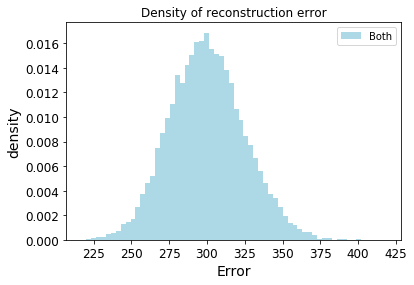

In [28]:
plt.hist(r[r<5000], normed = True, bins=62, color="lightblue", label="Both")
plt.xlabel('Error') ; plt.ylabel('density'); plt.title("Density of reconstruction error")
plt.legend()
plt.show()

### Average reconstr. error:

In [29]:
avg_rec_err = rec_err.groupby('latent').mean()
avg_rec_err 

,Error
latent,
0,300.019806
1,13642.721680


In [30]:
if float(avg_rec_err.iloc[1,:] - avg_rec_err.iloc[0,:]) > 0:
    print('Good! :-)')
else:
    print('Not good! :-(')

Good! :-)


### Plot conditional distribution of reconstruction error (given true state):

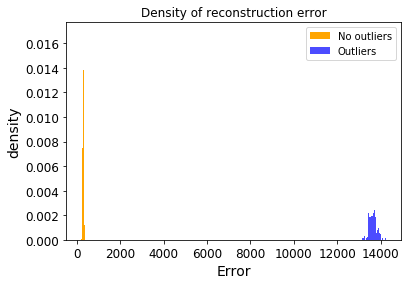

In [31]:
# Plot distributions given outlier(non-outlier):
plt.hist(rec_err.loc[rec_err['latent'] == 0, "Error"], normed = True, bins=62, color="orange", label="No outliers")
plt.hist(rec_err.loc[rec_err['latent'] == 1, "Error"], normed = True, bins=62, color="blue", alpha=.7, label="Outliers")
plt.xlabel('Error') ; plt.ylabel('density'); plt.title("Density of reconstruction error")
plt.legend()
plt.show()

### Plot learning curves:

In [32]:
dat = np.array(dat).T

In [33]:
dat.shape

(4, 7960)

In [34]:
def save_anim(data, figsize, filename):
  fig = plt.figure(figsize=(figsize[1]/10.0,figsize[0]/10.0))
  im = plt.imshow(data[0].reshape(figsize),cmap=plt.cm.gray,interpolation='none')
  plt.gca().set_axis_off()
  #fig.tight_layout()
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
  def updatefig(t):
    im.set_array(data[t].reshape(figsize))
    return im,
  anim = animation.FuncAnimation(fig, updatefig, frames=100, interval=50, blit=True, repeat=True)
  Writer = animation.writers['imagemagick']
  writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
  anim.save(filename, writer=writer)
  return

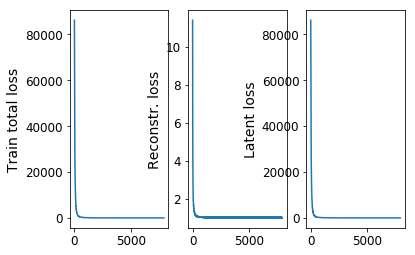

In [35]:
f,axarr = plt.subplots(1,3)
axarr[0].plot(dat[0],dat[1])
axarr[0].set_ylabel('Train total loss')
axarr[1].plot(dat[0],dat[2])
axarr[1].set_ylabel('Reconstr. loss')
axarr[2].plot(dat[0],dat[3])
axarr[2].set_ylabel('Latent loss')
#plt.title("Latent loss")

### Score new data using the pretrained model:  

In [36]:
def vae_score(x_batch, dec_thresh = None, **kwargs):
  """
  Compute the negative ELBO for a batch sample.
  Assign based on that cluster labels (outlier/non-outlier)
  """  
  with tf.Session() as sess:
      print("Loading pretrained model...")  
      saver.restore(sess, "/tmp/vae_model_final.ckpt")     # load final training checkpoint
      scored_batch = sess.run(reconstruct_loss_i, feed_dict={X: x_batch})
    
  quantiles_scores = None ;  
  if dec_thresh is None:
    quantiles_scores = np.percentile(scored_batch, **kwargs)
    dec_thresh = quantiles_scores[0]
  cluster_labels = scored_batch > dec_thresh
  return scored_batch, quantiles_scores, cluster_labels.astype('float32')


In [38]:
scored_x_test, quants, pred = vae_score(X_test_scaled, dec_thresh = 350.)         # data including outliers
#scored_x_train, quants, pred = vae_score(X_train_scaled, q = [.999])        # normal data


Loading pretrained model...
INFO:tensorflow:Restoring parameters from /tmp/vae_model_final.ckpt


In [39]:
# Test set (with both)
nelbo = pd.DataFrame(scored_x_test, columns=['NegELBO'], index = X_test_with_out.index)       # test

# Training set (with no outliers)
#nelbo = pd.DataFrame(scored_x_train, columns=['NegELBO'], index = X_train.index)               # train

# Assigned cluster labels ('Predictions')
#------------------------------------------
nelbo2 = nelbo.assign(pred=pred)

# True cluster labels (assignments):
#--------------------------------------
Nelbo = pd.concat([nelbo2,pd.DataFrame(X_test_with_out['latent'].astype('float32'),columns=['latent'], index = X_test_with_out.index)], axis=1, join="inner")
Nelbo.head()


,NegELBO,pred,latent
4270,322.689331,0.0,0.0
72104,281.445374,0.0,0.0
80554,342.281036,0.0,0.0
79236,316.203247,0.0,0.0
32048,322.983032,0.0,0.0


### Plot score distribution:

In [40]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 

sns.distplot(scored_x_train, fit=norm, norm_hist = True)        
# Get the fitted parameters:
(mu, sigma) = norm.fit(scored_x_train)
#print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('density') ; plt.title('log_subro_amount distribution')

# Get also the QQ-plot
#fig = plt.figure()
#res = stats.probplot(scored_x_train, plot=plt)
plt.show() 

NameError: name 'scored_x_train' is not defined

## Calculate classification performance metrics according to the calibrated decision function:

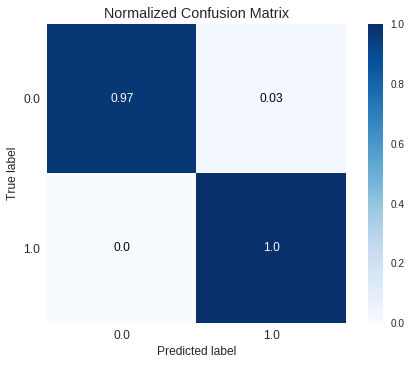

In [41]:
skplt.metrics.plot_confusion_matrix(Nelbo['latent'], Nelbo['pred'], normalize=True)

In [42]:
report = classification_report(Nelbo['latent'], Nelbo['pred'])       # given the partition above

print(report)

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     19902
         1.0       0.49      1.00      0.66       493

   micro avg       0.97      0.97      0.97     20395
   macro avg       0.75      0.99      0.82     20395
weighted avg       0.99      0.97      0.98     20395



In [43]:
accuracy_score(Nelbo['latent'], Nelbo['pred'])           # Accuracy

0.9748958077960285

In [44]:
roc_auc_score(Nelbo['latent'], Nelbo['pred'])               # Gini

0.9871369711586776

In [ ]:
# Run $ python -m tensorboard.main --logdir tf_logs/ in the terminal to get tensorboard started!
# or change port python -m tensorboard.main --logdir tf_logs/ --port=8008
logdir

In [ ]:
#import tensorboard

#file_writer = tf.summary.FileWriter('/work/Alex/Notebooks/Tensorflow_output', sess.graph)

In [ ]:
#!tensorboard --logdir=Tensorflow_output

#os.chdir('/work/Alex/Notebooks/'+"Tensorflow_output")
#os.getcwd()

In [ ]:
print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


## Generating samples

In [ ]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})
    